In [2]:
import torch
from torch import nn, optim, cuda
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from PIL import Image
import os
import csv
import random

In [3]:
class TrafficSignDataset(Dataset):
    def __init__(self, dir, file, transform):
        super().__init__()

        self.features = []
        self.labels = []

        self.dir = dir
        self.transform = transform
        self._read(os.path.join(dir, file))

    def _read(self, path):
        with open(path) as file:
            csv_reader = csv.reader(file)
            next(csv_reader)
            for row in csv_reader:
                self.features.append(self._load_image(row[7]))
                self.labels.append(int(row[6]))

    def _load_image(self, path):
        return self.transform(Image.open(os.path.join(self.dir, path)))

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        return (self.features[index], self.labels[index])

In [4]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

dataset_dir = "dataset"

dataset = TrafficSignDataset(dataset_dir, "Train.csv", transform)

valid_dataset_length = int(len(dataset) * 0.2)
train_dataset, valid_dataset = random_split(dataset, [len(dataset) - valid_dataset_length, valid_dataset_length])

test_dataset = TrafficSignDataset(dataset_dir, "Test.csv", transform)

In [5]:
classes = len(set(test_dataset.labels))
total_examples = len(train_dataset) + len(valid_dataset) + len(test_dataset)

print(f"Ukupan broj uzoraka = {total_examples}")
print(f"Broj uzoraka za trening = {len(train_dataset)} ({len(train_dataset)/total_examples*100:.2f}%)")
print(f"Broj uzoraka za validaciju = {len(valid_dataset)} ({len(valid_dataset)/total_examples*100:.2f}%)")
print(f"Broj uzoraka za testiranje = {len(test_dataset)} ({len(test_dataset)/total_examples*100:.2f}%)")
print(f"Broj klasa = {classes}")

Ukupan broj uzoraka = 51839
Broj uzoraka za trening = 31368 (60.51%)
Broj uzoraka za validaciju = 7841 (15.13%)
Broj uzoraka za testiranje = 12630 (24.36%)
Broj klasa = 43


In [7]:
class_names = []
with open(os.path.join(dataset_dir, "Meta.csv"), "r") as f:
    csv_reader = csv.reader(f)
    next(csv_reader)
    for row in csv_reader:
        class_names.append(row[1])

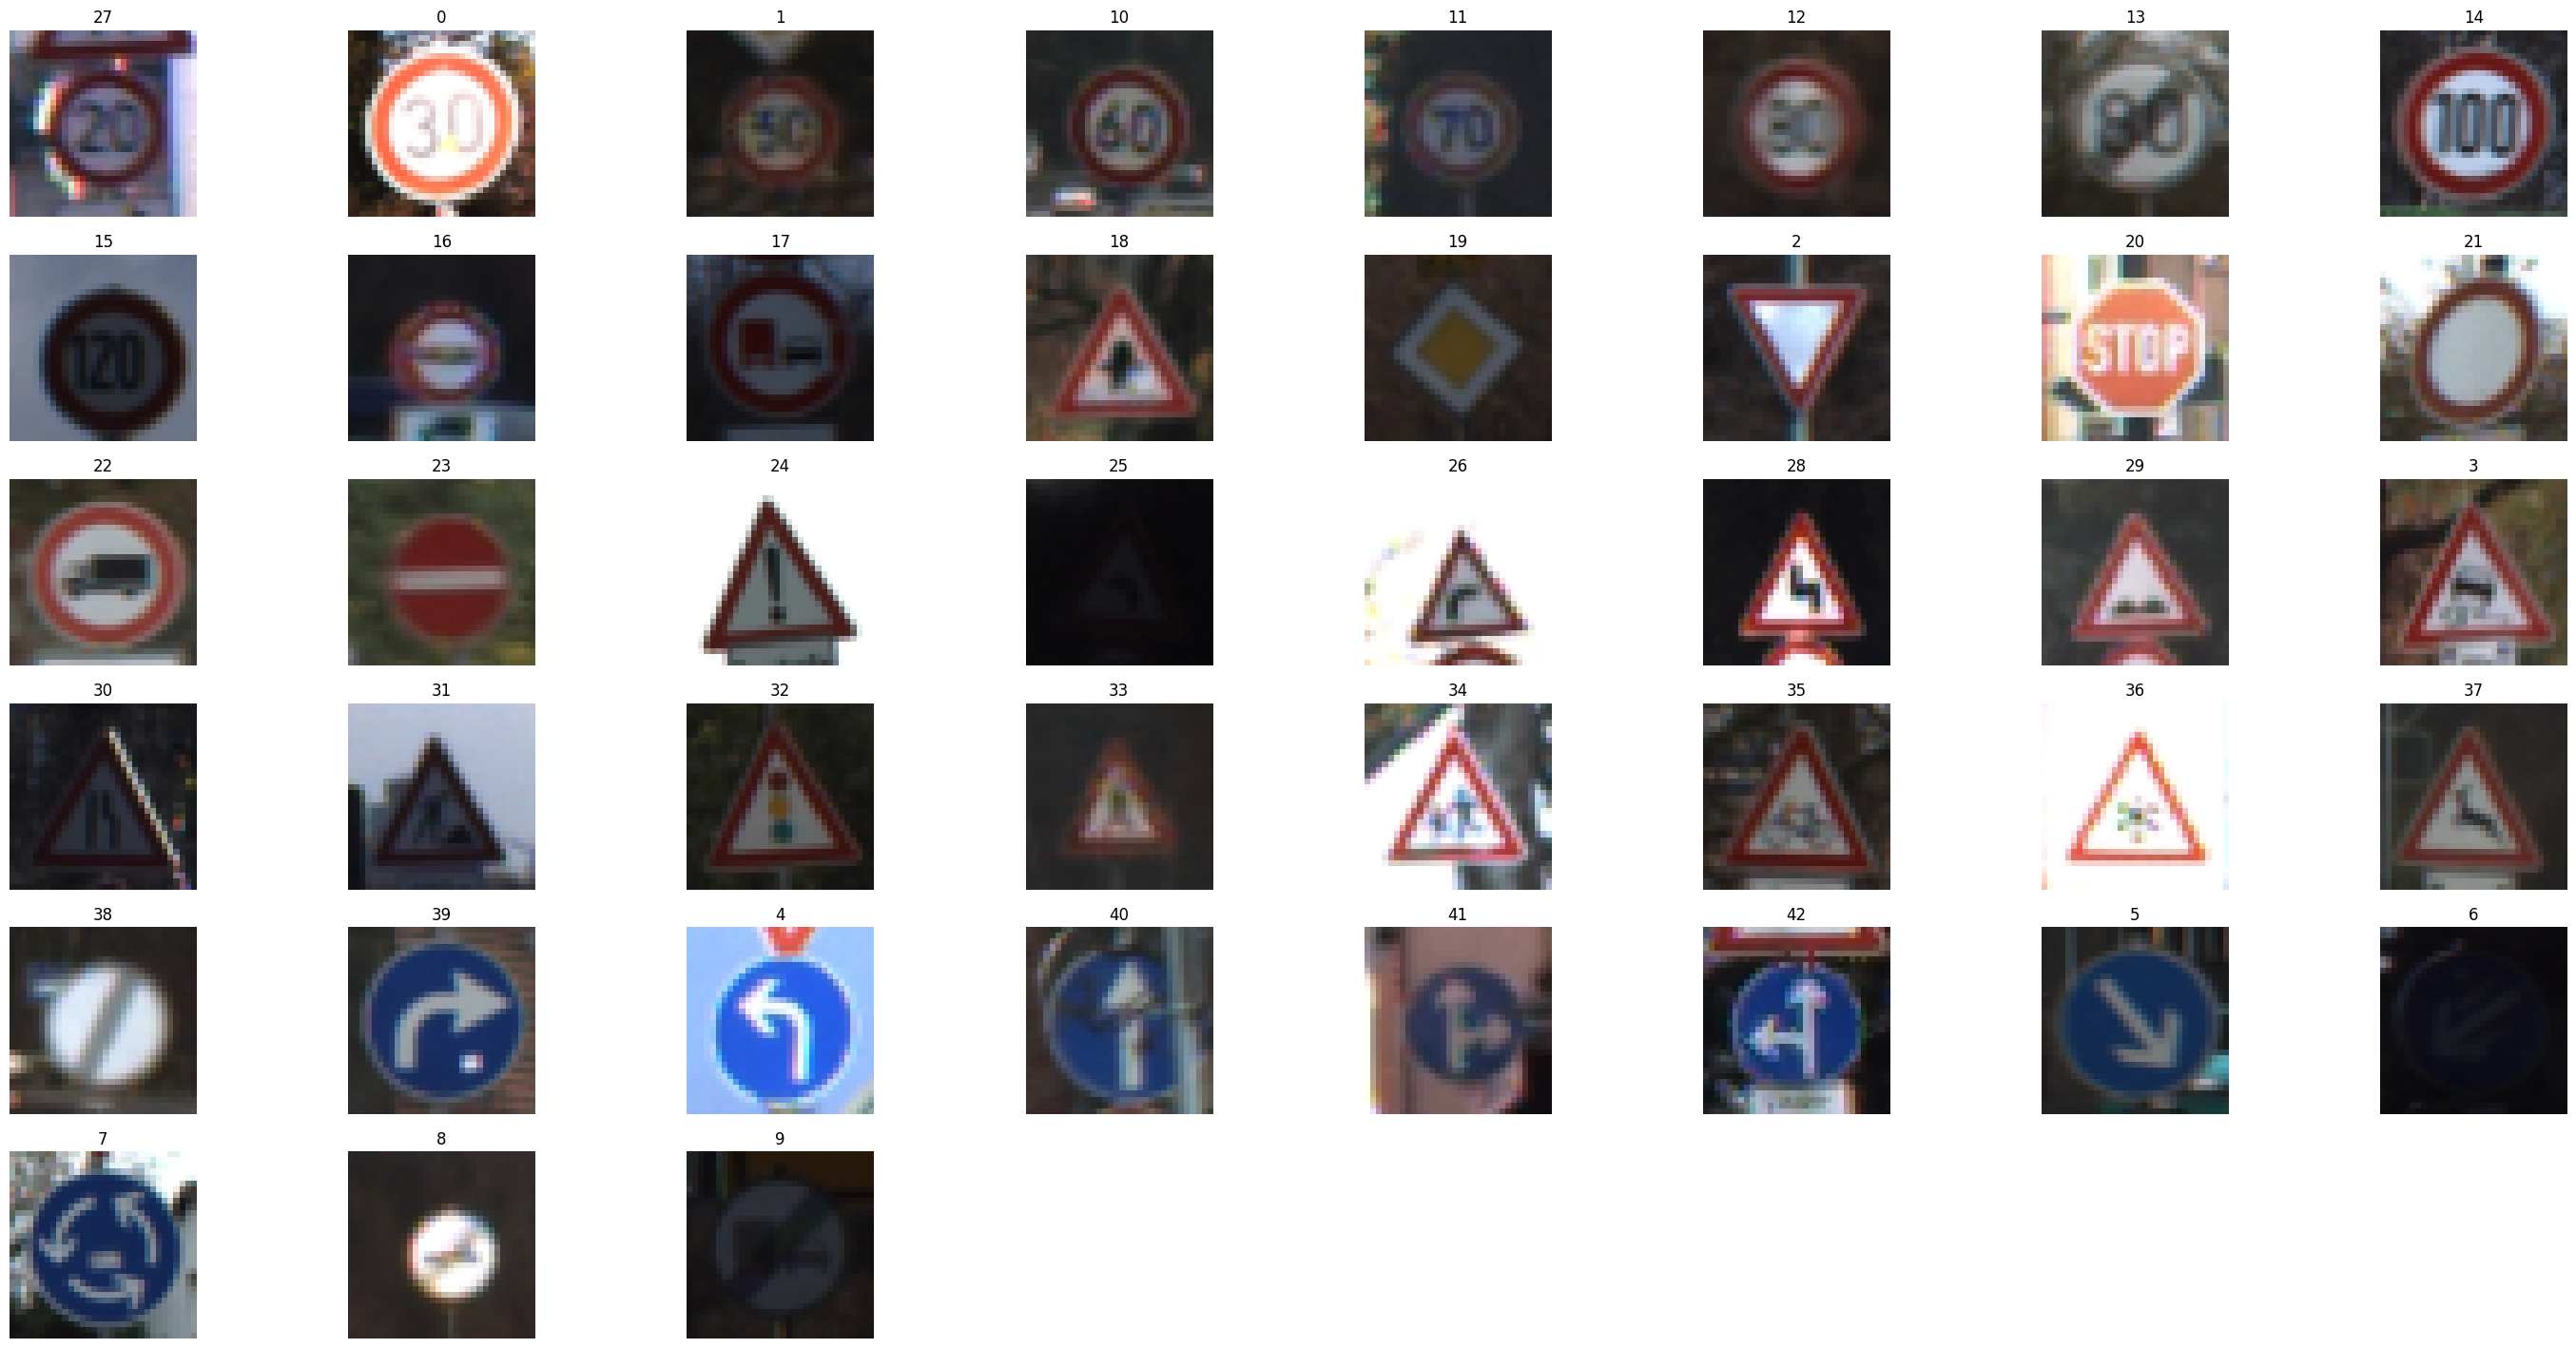

In [8]:
plt.figure(figsize=(36, 24))
labels = np.array(test_dataset.labels)

for c, class_name in enumerate(class_names):
    i = random.choice(np.where(labels == c)[0])
    plt.subplot(8, 8, c+1)
    plt.axis("off")
    plt.title(class_name)
    plt.imshow(np.transpose(test_dataset[i][0], (1, 2, 0)))

In [9]:
if cuda.is_available():
    device = torch.device("cuda")
    cuda.empty_cache()
else:
    device = torch.device("cpu")

print(f"Hardver koji ce se upotrebljivati = {device}")

def to_device(x, y):
    return x.to(device), y.to(device)

Hardver koji ce se upotrebljivati = cuda


In [10]:
class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

In [11]:
train_dl = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, shuffle=True), to_device) 
valid_dl = WrappedDataLoader(DataLoader(valid_dataset, batch_size=64, shuffle=False), to_device) 
test_dl = WrappedDataLoader(DataLoader(test_dataset, batch_size=64, shuffle=False), to_device)

In [12]:
def evaluate(model, loss_func, dl):
    loss = 0
    total = 0
    correct = 0

    with torch.no_grad():
        for d in dl:
            fv, y = d
            yp = model.forward(fv)
            loss += loss_func(yp, y)
            max_index = torch.argmax(yp, dim=1)
            total += yp.size(0)
            correct += (y == max_index).sum().item()

    return loss/len(dl), correct/total

In [13]:
def train(epochs, model, loss_func, optimizer, train_dl, valid_dl):
    for epoch in range(epochs):
        total_train_loss = 0

        for d in train_dl:
            fv, y = d
            optimizer.zero_grad()
            yp = model.forward(fv)
            loss = loss_func(yp, y)
            loss.backward()
            total_train_loss += loss
            optimizer.step()
        
        validation_loss, validation_accuracy = evaluate(model, loss_func, valid_dl)
        print(f"[Epoch {epoch+1}/{epochs}] Train loss: {total_train_loss / len(train_dl):.2f}\t"
                f"Validation loss: {validation_loss:.2f}\tValidation accuracy: {validation_accuracy * 100:.2f}%")

In [14]:
def test(model, loss_func, test_dl):
    test_loss, test_accuracy = evaluate(model, loss_func, test_dl)
    print(f"Test loss: {test_loss:.2f}\tTest accuracy: {test_accuracy * 100:.2f}%")

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [21]:
class LeNet(nn.Module):
    def __init__(self, classes):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [22]:
print(f"Model ima {count_parameters(LeNet(classes))} parametara koji mogu da se treniraju")

Model ima 64811 parametara koji mogu da se treniraju


In [23]:
lenet = LeNet(classes).to(device)
loss_function = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(lenet.parameters(), lr=0.001)
epochs = 20

In [24]:
train(epochs, lenet, loss_function, optimizer, train_dl, valid_dl)
test(lenet, loss_function, test_dl)

[Epoch 1/20] Train loss: 2.16	Validation loss: 0.92	Validation accuracy: 71.97%
[Epoch 2/20] Train loss: 0.63	Validation loss: 0.48	Validation accuracy: 85.84%
[Epoch 3/20] Train loss: 0.37	Validation loss: 0.32	Validation accuracy: 91.28%
[Epoch 4/20] Train loss: 0.27	Validation loss: 0.24	Validation accuracy: 93.51%
[Epoch 5/20] Train loss: 0.20	Validation loss: 0.18	Validation accuracy: 95.37%
[Epoch 6/20] Train loss: 0.16	Validation loss: 0.17	Validation accuracy: 95.50%
[Epoch 7/20] Train loss: 0.12	Validation loss: 0.15	Validation accuracy: 96.30%
[Epoch 8/20] Train loss: 0.11	Validation loss: 0.13	Validation accuracy: 96.71%
[Epoch 9/20] Train loss: 0.09	Validation loss: 0.13	Validation accuracy: 96.74%
[Epoch 10/20] Train loss: 0.07	Validation loss: 0.11	Validation accuracy: 97.21%
[Epoch 11/20] Train loss: 0.06	Validation loss: 0.11	Validation accuracy: 97.69%
[Epoch 12/20] Train loss: 0.06	Validation loss: 0.11	Validation accuracy: 97.39%
[Epoch 13/20] Train loss: 0.05	Valida

In [25]:
torch.save(lenet, "models/lenet.pth")

<AxesSubplot:>

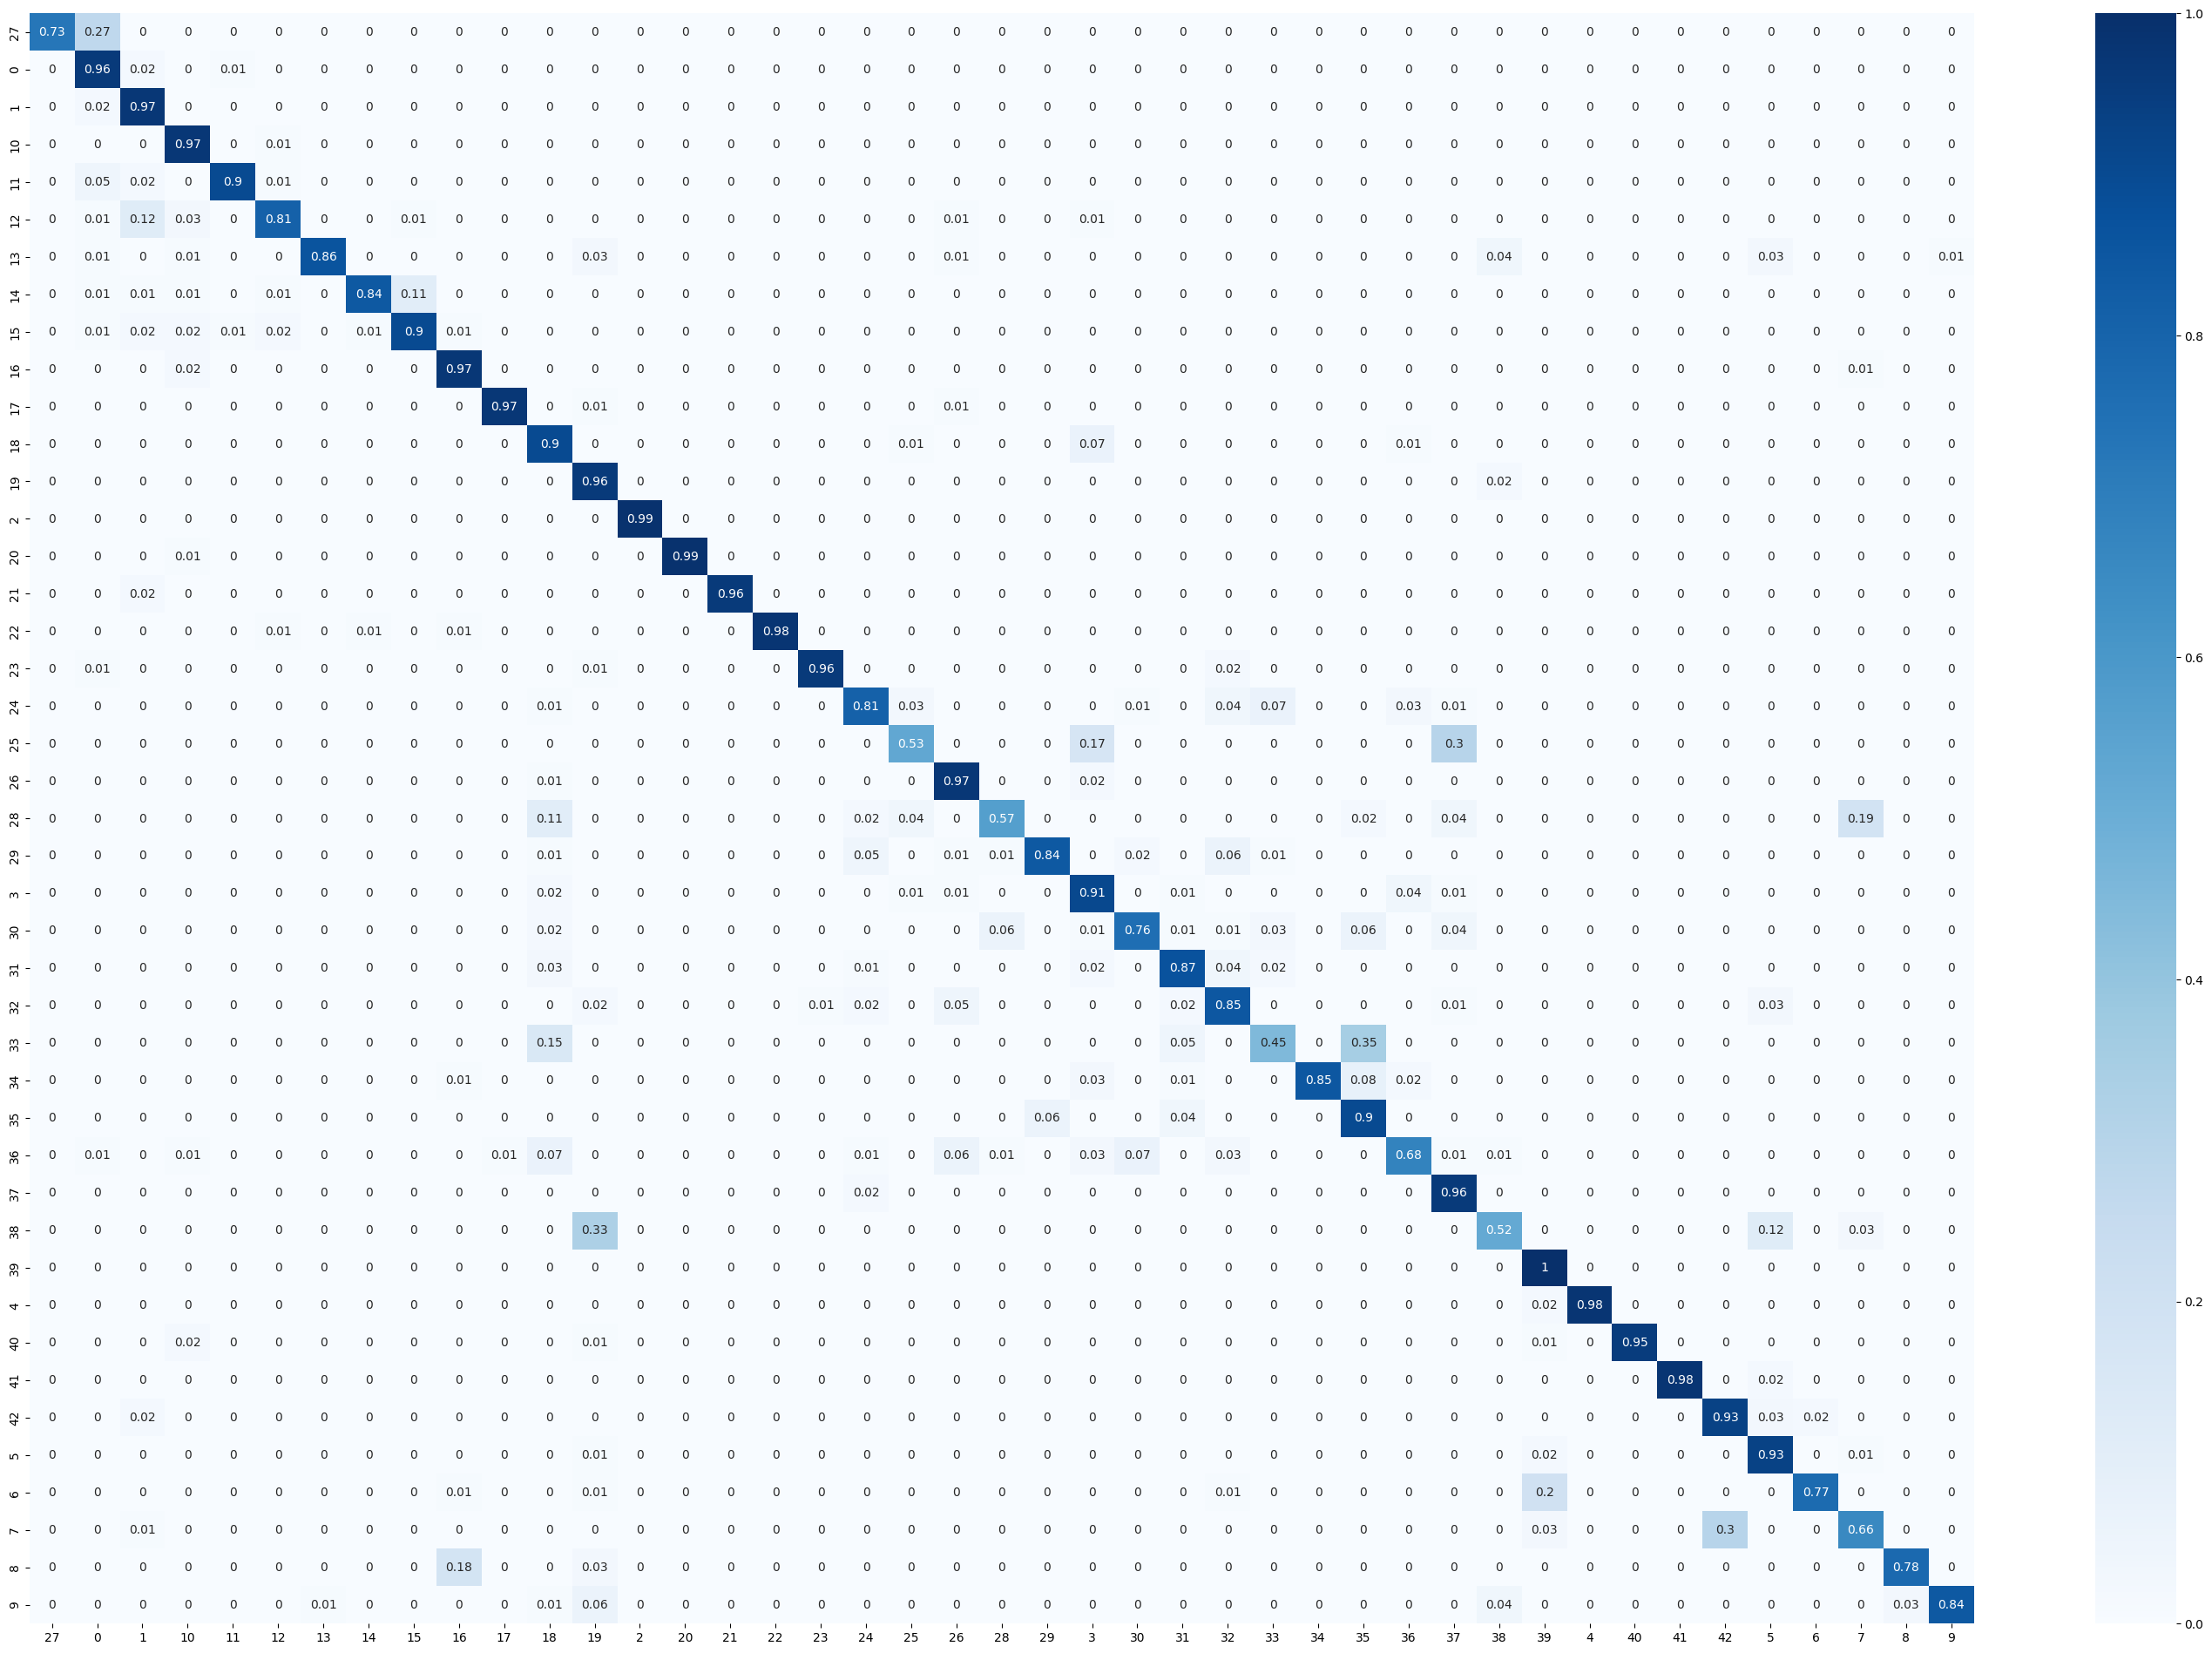

In [26]:
predictions = []
with torch.no_grad():
    for inputs, _ in test_dl: 
        predictions.extend(torch.argmax(lenet(inputs), dim=1).data.cpu().numpy())

cf_matrix = confusion_matrix(test_dataset.labels, predictions)

df_cm = pd.DataFrame(
    data = [row / np.sum(row) for row in cf_matrix],
    index = [i for i in class_names], 
    columns = [i for i in class_names]
).round(2)

plt.figure(figsize = (36,24))
sn.heatmap(df_cm, annot=True, cmap="Blues")